# Mine Events API

In [68]:
import json
import requests
import pprint
import pandas as pd
import numpy as np
import math

### Sample Game
May 7th 2022, NYR vs PIT, gameId=2021030143

##### Retrieve gameId

In [69]:
teamId = 3
date = '2022-05-07'

r = requests.get(url=f'https://statsapi.web.nhl.com/api/v1/schedule?date={date}')
d = r.json()
for g in d['dates'][0]['games']:
    print(g['gamePk'])
    
# set gameId to the rangers game for now
gameId = 2021030221
gameId

2021030113
2021030153
2021030143
2021030173


2021030221

### Retrive Game Events

* Collect Shots, blocked shots, missed shots, and goals
* blocked shots will have no goalie
* missed shots will have a no goalie and no blocker

In [70]:
# pull data from api
r = requests.get(url=f'https://statsapi.web.nhl.com/api/v1/game/{gameId}/feed/live')
d = r.json()
awayTeamId = d['gameData']['teams']['away']['id']
homeTeamId = d['gameData']['teams']['home']['id']
shots = [event for event in d['liveData']['plays']['allPlays'] \
         if event['result']['event'] in set(['Shot', 'Blocked Shot', 'Missed Shot', 'Goal']) ]

# get sets of fwd/def/goalies that appear in this game
forwards = set()
defensemen = set()
goalies = set()
for key, val in d['gameData']['players'].items():   
    if val['primaryPosition']['type'] == 'Forward':
        forwards.add(val['id'])
    elif val['primaryPosition']['type'] == 'Defenseman':
        defensemen.add(val['id'])
    elif val['primaryPosition']['type'] == 'Goalie':
        goalies.add(val['id'])

In [71]:
d['gameData']['teams']['away']['id']

3

In [72]:
gameInfo = {
    'gameId': d['gamePk'],
    'dateTime': d['gameData']['datetime']['dateTime'],
    'awayTeamId': d['gameData']['teams']['away']['id'],
    'homeTeamId': d['gameData']['teams']['home']['id']
}

roster = [{
    'playerId': player['id'],
    'firstName': player['firstName'],
    'lastName': player['lastName'],
    'primaryNumber': player['primaryNumber'],
    'birthCity': player['birthCity'],
    'birthCountry': player['birthCountry'],
    'nationality': player['nationality'],
    'height': player['height'],
    'weight': player['weight'],
    'shootsCatches': player['shootsCatches'],
    'teamId': player['currentTeam']['id'],
    'position': player['primaryPosition']['abbreviation'],
} for pid, player in d['gameData']['players'].items()]

In [73]:
teams = [{
    'teamId': team['id'],
    'name': team['name'],
    'locationName': team['locationName'],
    'teamName': team['teamName'],
    'abbreviation': team['abbreviation'],
    'division': team['division']['nameShort'],
    'conference': team['conference']['name'],
    'firstYearOfPlay': team['firstYearOfPlay'],
    'venue': team['venue']['name'],
    'timezone': team['venue']['timeZone']['tz']
} for homeaway, team in d['gameData']['teams'].items()]

In [74]:
# for homeaway, team in d['gameData']['teams'].items():
#     pprint.pprint(team)
teams

[{'teamId': 3,
  'name': 'New York Rangers',
  'locationName': 'New York',
  'teamName': 'Rangers',
  'abbreviation': 'NYR',
  'division': 'Metro',
  'conference': 'Eastern',
  'firstYearOfPlay': '1926',
  'venue': 'Madison Square Garden',
  'timezone': 'EDT'},
 {'teamId': 12,
  'name': 'Carolina Hurricanes',
  'locationName': 'Carolina',
  'teamName': 'Hurricanes',
  'abbreviation': 'CAR',
  'division': 'Metro',
  'conference': 'Eastern',
  'firstYearOfPlay': '1997',
  'venue': 'PNC Arena',
  'timezone': 'EDT'}]

In [75]:
def calc_gametime_second(period, time):
    time_in_seconds = int(time[:2]) * 60 + int(time[3:])
    return (period - 1) * 1200 + time_in_seconds

In [76]:
shots[0]
# [s['result']['secondaryType'] for s in shots if 'secondaryType' in s['result']]

{'players': [{'player': {'id': 8477488,
    'fullName': 'Brett Pesce',
    'link': '/api/v1/people/8477488'},
   'playerType': 'Shooter'},
  {'player': {'id': 8478048,
    'fullName': 'Igor Shesterkin',
    'link': '/api/v1/people/8478048'},
   'playerType': 'Unknown'}],
 'result': {'event': 'Missed Shot',
  'eventCode': 'CAR8',
  'eventTypeId': 'MISSED_SHOT',
  'description': 'Brett Pesce Wide of Net Igor Shesterkin'},
 'about': {'eventIdx': 5,
  'eventId': 8,
  'period': 1,
  'periodType': 'REGULAR',
  'ordinalNum': '1st',
  'periodTime': '01:03',
  'periodTimeRemaining': '18:57',
  'dateTime': '2022-05-18T23:11:56Z',
  'goals': {'away': 0, 'home': 0}},
 'coordinates': {'x': -35.0, 'y': 33.0},
 'team': {'id': 12,
  'name': 'Carolina Hurricanes',
  'link': '/api/v1/teams/12',
  'triCode': 'CAR'}}

In [77]:
# extract shots
shot_data = []
teamIds = [t['teamId'] for t in teams]
for shot in shots:
    shooter = 0
    goalie = 0
    blocker = 0
    for player in shot['players']:
        if player['playerType'] == 'Shooter' or player['playerType'] == 'Scorer':
            shooter = player['player']['id']
        if player['playerType'] == 'Goalie':
            goalie = player['player']['id']
        if player['playerType'] == 'Blocker':
            blocker = player['player']['id']    
            
    # get correct teamId...if blocked shot, flip teamId
    teamId = shot['team']['id']
    if shot['result']['eventTypeId'] == 'BLOCKED_SHOT':
        if teamId == teamIds[0]:
            teamId = teamIds[1]
        else:
            teamId = teamIds[0]
            
    # normalized shot locations
    x = shot['coordinates']['x']
    y = shot['coordinates']['y']
    if shot['about']['period'] % 2 == 0: # e.g., 2nd period, 1st ot period, 3rd ot period
        x = -1*x
        y = -1*y
        
    # get shot type if shot was on net
    shot_type = 'none'
    if 'secondaryType' in shot['result']:
        shot_type = shot['result']['secondaryType']
    
    shot_data.append({
        'shooterId': shooter,
        'goalieId': goalie,
        'blockerId': blocker,
        'teamId': teamId,
        'x': x,
        'y': y,
        'time': calc_gametime_second(shot['about']['period'], shot['about']['periodTime']),
        'type': shot['result']['eventTypeId'],
        'shot_type': shot_type
    })

In [78]:
# read as dataframe
df_shots = pd.DataFrame(shot_data)
df_shots.head()

,shooterId,goalieId,blockerId,teamId,x,y,time,type,shot_type
0,8477488,0,0,12,-35.0,33.0,63,MISSED_SHOT,none
1,8476869,0,0,12,-32.0,-20.0,78,MISSED_SHOT,none
2,8473533,0,0,12,-64.0,-11.0,96,MISSED_SHOT,none
3,8476885,8477293,0,3,38.0,-21.0,133,SHOT,Snap Shot
4,8477429,0,8478427,3,60.0,10.0,141,BLOCKED_SHOT,none


In [79]:
df_shots.tail()

,shooterId,goalieId,blockerId,teamId,x,y,time,type,shot_type
116,8476885,8477293,0,3,80.0,-39.0,3716,SHOT,Snap Shot
117,8476389,8478048,0,12,-73.0,-4.0,3753,SHOT,Backhand
118,8476389,0,0,12,-81.0,-22.0,3755,MISSED_SHOT,none
119,8474090,0,0,12,-35.0,25.0,3789,MISSED_SHOT,none
120,8474013,8478048,0,12,-56.0,8.0,3792,GOAL,Wrist Shot


<AxesSubplot:xlabel='x', ylabel='y'>

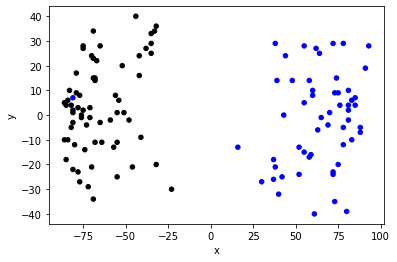

In [80]:
# generate sample plots to ensure shot location transformations are correct
df_tmp = df_shots.copy()
# df_tmp = df_shots[df_shots['time'] < 1200] # 1st period
# df_tmp = df_shots[(df_shots['time'] > 1200) & (df_shots['time'] < 2400)] # 2nd period
# df_tmp = df_shots[(df_shots['time'] > 2400) & (df_shots['time'] < 3600)] # 2nd period

df_tmp['color'] = np.where(df_tmp['teamId']==3, 'blue', 'black')


df_tmp.plot.scatter(x='x', y='y',c='color')

### Retrieve Time on Ice data

Start by retrieving data from api

In [81]:
def calc_gametime_second(period, time):
    time_in_seconds = int(time[:2]) * 60 + int(time[3:])
    return (period - 1) * 1200 + time_in_seconds

def extract_json_shifts(d):
    return [{
        'gameId': shift['gameId'],
        'teamId': shift['teamId'],
        'playerId': shift['playerId'],
        'start': calc_gametime_second(shift['period'], shift['startTime']),
        'end': calc_gametime_second(shift['period'], shift['endTime'])
    } for shift in d['data']]

In [82]:
all_shifts = []
try:
    # get data for this game_id
    r = requests.get(url=f'https://api.nhle.com/stats/rest/en/shiftcharts?cayenneExp=gameId={gameId}')
    d = r.json()

    # extract shift data
    all_shifts.extend(extract_json_shifts(d))

except:
    print('could not fetch gameId: ' + gameId)

In [83]:
# convert to df
df_shifts = pd.DataFrame(all_shifts)

# some shifts are recorded with identical start/end times, omit these rows
df_shifts = df_shifts[df_shifts['start'] != df_shifts['end']]

# sort df
df_shifts = df_shifts.sort_values(['gameId', 'teamId', 'start', 'end', 'playerId'])
df_shifts.head(10)

,gameId,teamId,playerId,start,end
272,2021030221,3,8476885,0,31
630,2021030221,3,8480817,0,31
332,2021030221,3,8477353,0,38
521,2021030221,3,8479291,0,38
0,2021030221,3,8471817,0,39
438,2021030221,3,8478048,0,1200
570,2021030221,3,8479324,31,86
542,2021030221,3,8479323,31,113
95,2021030221,3,8475184,38,113
203,2021030221,3,8476459,38,113


In [84]:
# convert back to dict so we can identify line combinations
shifts = df_shifts.to_dict(orient='records')
shifts[0]

{'gameId': 2021030221, 'teamId': 3, 'playerId': 8476885, 'start': 0, 'end': 31}

In [88]:
df_shifts.tail(12)

,gameId,teamId,playerId,start,end
331,2021030221,12,8477293,3600,3792
485,2021030221,12,8478427,3669,3708
271,2021030221,12,8476882,3669,3720
437,2021030221,12,8477950,3685,3734
753,2021030221,12,8482093,3686,3724
327,2021030221,12,8476958,3687,3745
179,2021030221,12,8476389,3708,3778
695,2021030221,12,8480830,3720,3792
610,2021030221,12,8480039,3724,3792
57,2021030221,12,8474013,3734,3792


##### Then group players by line

In [89]:
def line_list_to_shift(line_list, start, end):
    # need this for when dataset changes from teamId_1 to teamId_2
    # ...corrects end time of final shift 'first' team's shift data
    if end <= start:
        end = line_list[0]['end']
    return {
        'playerIds': [player['playerId'] for player in line_list],
        'start': start,
        'end': end,
        'numPlayers': len(line_list),
        'teamId': line_list[0]['teamId']
    }

def next_shift_end(line_list):
    return min([player['end'] for player in line_list])

In [110]:
# get starting lines
start_time = shifts[0]['start']
line_list = []
line_shifts = []
i = 0
more_shifts = True

while more_shifts and i < len(shifts): #and shifts[i]['teamId'] == 6:
    # add players starting shift
    while start_time == shifts[i]['start']:
        line_list.append(shifts[i])
        i += 1
        if i == len(shifts):
            i -= 1 # at the end of shifts data for this game
            more_shifts = False
            break
    
    # figure out the time when the next player is getting on/off the ice
    next_player_off = next_shift_end(line_list)
    next_player_on = shifts[i]['start']
    end_time = min([next_player_off, next_player_on])

    # new player getting on, save this line combination
    line_shifts.append(line_list_to_shift(line_list, start_time, end_time))

    # cut list to only contain players that remain on the ice after end_time
    line_list = [player for player in line_list if player['end'] > end_time]
    
    # if reached end of shifts for this game for this team, clear line_list
    if next_player_on == 0:
        line_list = []

    # update start_time with time that new player(s) are getting on the ice
    start_time = end_time

In [112]:
df_tmp = pd.DataFrame(line_shifts)
df_tmp[df_tmp['teamId']==12].tail()

,playerIds,start,end,numPlayers,teamId
541,"[8477293, 8477950, 8482093, 8476958, 8476389, ...",3720,3724,6,12
542,"[8477293, 8477950, 8476958, 8476389, 8480830, ...",3724,3734,6,12
543,"[8477293, 8476958, 8476389, 8480830, 8480039, ...",3734,3745,6,12
544,"[8477293, 8476389, 8480830, 8480039, 8474013, ...",3745,3778,6,12
545,"[8477293, 8480830, 8480039, 8474013, 8474090, ...",3778,3792,6,12


##### Next compute the num players on the ice for each team

This will help with calculating scenarios in SQL queries (e.g., 5on5 or 5on4)

In [113]:
away_shifts = [s for s in line_shifts if s['teamId']==awayTeamId]
away_shifts_frames = []
for s in away_shifts:
    for i in range(s['start'], s['end']):
        away_shifts_frames.append({
            'awayPlayerIds': s['playerIds'],
            'time': i
        })
    # add last second (fixes overtime goals that don't get recorded)
    away_shifts_frames.append({
        'awayPlayerIds': s['playerIds'],
        'time': i+1
    })
        
home_shifts = [s for s in line_shifts if s['teamId']==homeTeamId]
home_shifts_frames = []
for s in home_shifts:
    for i in range(s['start'], s['end']):
        home_shifts_frames.append({
            'homePlayerIds': s['playerIds'],
            'time': i
        })
    # add last second (fixes overtime goals that don't get recorded)
    home_shifts_frames.append({
            'homePlayerIds': s['playerIds'],
            'time': i+1
    })

In [114]:
line_shifts

[{'playerIds': [8476885, 8480817, 8477353, 8479291, 8471817, 8478048],
  'start': 0,
  'end': 31,
  'numPlayers': 6,
  'teamId': 3},
 {'playerIds': [8477353, 8479291, 8471817, 8478048, 8479324, 8479323],
  'start': 31,
  'end': 38,
  'numPlayers': 6,
  'teamId': 3},
 {'playerIds': [8471817, 8478048, 8479324, 8479323, 8475184, 8476459],
  'start': 38,
  'end': 39,
  'numPlayers': 6,
  'teamId': 3},
 {'playerIds': [8478048, 8479324, 8479323, 8475184, 8476459, 8478366],
  'start': 39,
  'end': 86,
  'numPlayers': 6,
  'teamId': 3},
 {'playerIds': [8478048, 8479323, 8475184, 8476459, 8476458, 8478550],
  'start': 86,
  'end': 113,
  'numPlayers': 6,
  'teamId': 3},
 {'playerIds': [8478048, 8480817, 8481554, 8476885, 8477429],
  'start': 113,
  'end': 144,
  'numPlayers': 5,
  'teamId': 3},
 {'playerIds': [8478048, 8476885, 8477429, 8479323, 8482109],
  'start': 144,
  'end': 174,
  'numPlayers': 5,
  'teamId': 3},
 {'playerIds': [8478048, 8477429, 8479323, 8482109, 8479324],
  'start': 174

In [115]:
df = pd.DataFrame(away_shifts_frames).merge(pd.DataFrame(home_shifts_frames), on='time')
df = df[['time', 'awayPlayerIds', 'homePlayerIds']]
df['awayNumPlayers'] = df['awayPlayerIds'].str.len()
df['homeNumPlayers'] = df['homePlayerIds'].str.len()
df

,time,awayPlayerIds,homePlayerIds,awayNumPlayers,homeNumPlayers
0,0,"[8476885, 8480817, 8477353, 8479291, 8471817, ...","[8474013, 8480039, 8480829, 8474090, 8478904, ...",6,6
1,1,"[8476885, 8480817, 8477353, 8479291, 8471817, ...","[8474013, 8480039, 8480829, 8474090, 8478904, ...",6,6
2,2,"[8476885, 8480817, 8477353, 8479291, 8471817, ...","[8474013, 8480039, 8480829, 8474090, 8478904, ...",6,6
3,3,"[8476885, 8480817, 8477353, 8479291, 8471817, ...","[8474013, 8480039, 8480829, 8474090, 8478904, ...",6,6
4,4,"[8476885, 8480817, 8477353, 8479291, 8471817, ...","[8474013, 8480039, 8480829, 8474090, 8478904, ...",6,6
...,...,...,...,...,...
4395,3788,"[8478048, 8481554, 8476885, 8479324, 8482109, ...","[8477293, 8480830, 8480039, 8474013, 8474090, ...",6,6
4396,3789,"[8478048, 8481554, 8476885, 8479324, 8482109, ...","[8477293, 8480830, 8480039, 8474013, 8474090, ...",6,6
4397,3790,"[8478048, 8481554, 8476885, 8479324, 8482109, ...","[8477293, 8480830, 8480039, 8474013, 8474090, ...",6,6
4398,3791,"[8478048, 8481554, 8476885, 8479324, 8482109, ...","[8477293, 8480830, 8480039, 8474013, 8474090, ...",6,6


##### Separate playerIds by position
make columns for fwd/def/goalie and serialize data (i.e., [8476885, 8480817, 8476459] -> '8476885_8480817_8476459')

In [116]:
df['awayPlayerIds'][0]

[8476885, 8480817, 8477353, 8479291, 8471817, 8478048]

In [117]:
timeframes = df.to_dict(orient='records')

In [118]:
def serialize_ids(playerIds):
    return '_'.join(str(i) for i in sorted(playerIds))

In [119]:
serialized_shifts = []
for t in timeframes:
    serialized_shifts.append({
        'gameId': gameId,
        'time': t['time'],
        'awayNumPlayers': t['awayNumPlayers'],
        'awayFwdIds': serialize_ids([playerId for playerId in t['awayPlayerIds'] if playerId in forwards]),
        'awayDefIds': serialize_ids([playerId for playerId in t['awayPlayerIds'] if playerId in defensemen]),
        'awayGoalieIds': serialize_ids([playerId for playerId in t['awayPlayerIds'] if playerId in goalies]),
        'homeFwdIds': serialize_ids([playerId for playerId in t['homePlayerIds'] if playerId in forwards]),
        'homeDefIds': serialize_ids([playerId for playerId in t['homePlayerIds'] if playerId in defensemen]),
        'homeGoalieIds': serialize_ids([playerId for playerId in t['homePlayerIds'] if playerId in goalies]),
        'homeNumPlayers': t['homeNumPlayers']
    })

In [120]:
df = pd.DataFrame(serialized_shifts)
df.head()

,gameId,time,awayNumPlayers,awayFwdIds,awayDefIds,awayGoalieIds,homeFwdIds,homeDefIds,homeGoalieIds,homeNumPlayers
0,2021030221,0,6,8471817_8477353_8479291,8476885_8480817,8478048,8478904_8480039_8480829,8474013_8474090,8477293,6
1,2021030221,1,6,8471817_8477353_8479291,8476885_8480817,8478048,8478904_8480039_8480829,8474013_8474090,8477293,6
2,2021030221,2,6,8471817_8477353_8479291,8476885_8480817,8478048,8478904_8480039_8480829,8474013_8474090,8477293,6
3,2021030221,3,6,8471817_8477353_8479291,8476885_8480817,8478048,8478904_8480039_8480829,8474013_8474090,8477293,6
4,2021030221,4,6,8471817_8477353_8479291,8476885_8480817,8478048,8478904_8480039_8480829,8474013_8474090,8477293,6


In [121]:
df.tail()

,gameId,time,awayNumPlayers,awayFwdIds,awayDefIds,awayGoalieIds,homeFwdIds,homeDefIds,homeGoalieIds,homeNumPlayers
4395,2021030221,3788,6,8479291_8481554_8482109,8476885_8479324,8478048,8480039_8480829_8480830,8474013_8474090,8477293,6
4396,2021030221,3789,6,8479291_8481554_8482109,8476885_8479324,8478048,8480039_8480829_8480830,8474013_8474090,8477293,6
4397,2021030221,3790,6,8479291_8481554_8482109,8476885_8479324,8478048,8480039_8480829_8480830,8474013_8474090,8477293,6
4398,2021030221,3791,6,8479291_8481554_8482109,8476885_8479324,8478048,8480039_8480829_8480830,8474013_8474090,8477293,6
4399,2021030221,3792,6,8479291_8481554_8482109,8476885_8479324,8478048,8480039_8480829_8480830,8474013_8474090,8477293,6


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400 entries, 0 to 4399
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gameId          4400 non-null   int64 
 1   time            4400 non-null   int64 
 2   awayNumPlayers  4400 non-null   int64 
 3   awayFwdIds      4400 non-null   object
 4   awayDefIds      4400 non-null   object
 5   awayGoalieIds   4400 non-null   object
 6   homeFwdIds      4400 non-null   object
 7   homeDefIds      4400 non-null   object
 8   homeGoalieIds   4400 non-null   object
 9   homeNumPlayers  4400 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 343.9+ KB


### Create minutes df

In [123]:
# compute scenario of each timeframe
numHome = df['homeNumPlayers']
numAway = df['awayNumPlayers']
df['scenario'] = np.where((numHome==6) & (numAway==6), '5on5',
                         np.where((numHome==6) & (numAway==5), '5on4',
                                 np.where((numHome==5) & (numAway==6), '5on4',
                                         np.where((numHome==5) & (numAway==5), '4on4',
                                                 np.where((numHome==5) & (numAway==4), '4on3',
                                                         np.where((numHome==4) & (numAway==5), '4on3',
                                                                 np.where((numHome==4) & (numAway==4), '3on3', 'other')
                                                                 )
                                                         )
                                                 )
                                         )
                                 )
                         )
df['scenario'] = np.where((df['awayGoalieIds'].str.len()<7) | (df['homeGoalieIds'].str.len()<7), 
                          'emptyNet', 
                          df['scenario'])
df

,gameId,time,awayNumPlayers,awayFwdIds,awayDefIds,awayGoalieIds,homeFwdIds,homeDefIds,homeGoalieIds,homeNumPlayers,scenario
0,2021030221,0,6,8471817_8477353_8479291,8476885_8480817,8478048,8478904_8480039_8480829,8474013_8474090,8477293,6,5on5
1,2021030221,1,6,8471817_8477353_8479291,8476885_8480817,8478048,8478904_8480039_8480829,8474013_8474090,8477293,6,5on5
2,2021030221,2,6,8471817_8477353_8479291,8476885_8480817,8478048,8478904_8480039_8480829,8474013_8474090,8477293,6,5on5
3,2021030221,3,6,8471817_8477353_8479291,8476885_8480817,8478048,8478904_8480039_8480829,8474013_8474090,8477293,6,5on5
4,2021030221,4,6,8471817_8477353_8479291,8476885_8480817,8478048,8478904_8480039_8480829,8474013_8474090,8477293,6,5on5
...,...,...,...,...,...,...,...,...,...,...,...
4395,2021030221,3788,6,8479291_8481554_8482109,8476885_8479324,8478048,8480039_8480829_8480830,8474013_8474090,8477293,6,5on5
4396,2021030221,3789,6,8479291_8481554_8482109,8476885_8479324,8478048,8480039_8480829_8480830,8474013_8474090,8477293,6,5on5
4397,2021030221,3790,6,8479291_8481554_8482109,8476885_8479324,8478048,8480039_8480829_8480830,8474013_8474090,8477293,6,5on5
4398,2021030221,3791,6,8479291_8481554_8482109,8476885_8479324,8478048,8480039_8480829_8480830,8474013_8474090,8477293,6,5on5


In [124]:
df[df['scenario']=='emptyNet']

,gameId,time,awayNumPlayers,awayFwdIds,awayDefIds,awayGoalieIds,homeFwdIds,homeDefIds,homeGoalieIds,homeNumPlayers,scenario


In [125]:
df[['time', 'awayFwdIds', 'scenario']]

,time,awayFwdIds,scenario
0,0,8471817_8477353_8479291,5on5
1,1,8471817_8477353_8479291,5on5
2,2,8471817_8477353_8479291,5on5
3,3,8471817_8477353_8479291,5on5
4,4,8471817_8477353_8479291,5on5
...,...,...,...
4395,3788,8479291_8481554_8482109,5on5
4396,3789,8479291_8481554_8482109,5on5
4397,3790,8479291_8481554_8482109,5on5
4398,3791,8479291_8481554_8482109,5on5


In [126]:
timeframes = df.to_dict(orient='records')
timeframes[0]

{'gameId': 2021030221,
 'time': 0,
 'awayNumPlayers': 6,
 'awayFwdIds': '8471817_8477353_8479291',
 'awayDefIds': '8476885_8480817',
 'awayGoalieIds': '8478048',
 'homeFwdIds': '8478904_8480039_8480829',
 'homeDefIds': '8474013_8474090',
 'homeGoalieIds': '8477293',
 'homeNumPlayers': 6,
 'scenario': '5on5'}

In [127]:
shifts = []
homeTeamId = 5
awayTeamId = 3
cats = ['awayFwdIds', 'awayDefIds', 'awayGoalieIds',
       'homeFwdIds', 'homeDefIds', 'homeGoalieIds']

for cat in cats:
    teamId = homeTeamId
    if 'away' in cat:
        teamId = awayTeamId
    lineType = 'fwd'
    if 'Def' in cat:
        lineType = 'def'
    elif 'Goalie' in cat:
        lineType = 'goalie'
        
    start = 0
    cur_line = timeframes[0][cat]
    cur_scenario = timeframes[0]['scenario']

    for i in range(1,len(timeframes)):
        if timeframes[i][cat] != cur_line or timeframes[i]['scenario'] != cur_scenario:
            if cur_line != '':
                shifts.append({
                    'start': start,
                    'end': i,
                    'duration': i-start,
                    'gameId': gameId,
                    'teamId': teamId,
                    'lineId': cur_line,
                    'lineType': lineType,
                    'scenario': cur_scenario
                })

            start = i
            cur_line = timeframes[i][cat]
            cur_scenario = timeframes[i]['scenario']
    shifts.append({
        'start': start,
        'end': i,
        'duration': i-start,
        'gameId': gameId,
        'teamId': teamId,
        'lineId': cur_line,
        'lineType': lineType,
        'scenario': cur_scenario
    })

In [128]:
df_shifts = pd.DataFrame(shifts)

In [129]:
df_shifts.sort_values(['end', 'start'], ascending=False)

,start,end,duration,gameId,teamId,lineId,lineType,scenario
657,4385,4399,14,2021030221,5,8480039_8480829_8480830,fwd,5on5
207,4352,4399,47,2021030221,3,8479291_8481554_8482109,fwd,5on5
839,4350,4399,49,2021030221,5,8474013_8474090,def,5on5
357,4316,4399,83,2021030221,3,8476885_8479324,def,5on5
364,269,4399,4130,2021030221,3,8478048,goalie,5on5
...,...,...,...,...,...,...,...,...
1,41,43,2,2021030221,3,8471817_8475184_8476459,fwd,5on5
0,0,41,41,2021030221,3,8471817_8477353_8479291,fwd,5on5
365,0,39,39,2021030221,5,8478904_8480039_8480829,fwd,5on5
658,0,39,39,2021030221,5,8474013_8474090,def,5on5


In [130]:
df_shifts[(df_shifts['teamId']==3) & (df_shifts['lineType']=='fwd')]

,start,end,duration,gameId,teamId,lineId,lineType,scenario
0,0,41,41,2021030221,3,8471817_8477353_8479291,fwd,5on5
1,41,43,2,2021030221,3,8471817_8475184_8476459,fwd,5on5
2,43,93,50,2021030221,3,8475184_8476459_8478366,fwd,5on5
3,93,94,1,2021030221,3,8475184_8476459_8478366,fwd,5on4
4,94,95,1,2021030221,3,8475184_8476458_8476459_8478550,fwd,5on5
...,...,...,...,...,...,...,...,...
203,4263,4285,22,2021030221,3,8476458_8477429_8478550,fwd,5on5
204,4285,4295,10,2021030221,3,8476458_8478550_8481554,fwd,5on5
205,4295,4324,29,2021030221,3,8478550_8480078_8481554,fwd,5on5
206,4324,4352,28,2021030221,3,8480078_8481554_8482109,fwd,5on5


In [131]:
df_shifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   start     847 non-null    int64 
 1   end       847 non-null    int64 
 2   duration  847 non-null    int64 
 3   gameId    847 non-null    int64 
 4   teamId    847 non-null    int64 
 5   lineId    847 non-null    object
 6   lineType  847 non-null    object
 7   scenario  847 non-null    object
dtypes: int64(5), object(3)
memory usage: 53.1+ KB


### Merge shot and timeframe df

In [132]:
df_shot_players = df_shots.merge(df, on='time')
df_shot_players

,shooterId,goalieId,blockerId,teamId,x,y,time,type,shot_type,gameId,awayNumPlayers,awayFwdIds,awayDefIds,awayGoalieIds,homeFwdIds,homeDefIds,homeGoalieIds,homeNumPlayers,scenario
0,8477488,0,0,12,-35.0,33.0,63,MISSED_SHOT,none,2021030221,6,8475184_8476459_8478366,8479323_8479324,8478048,8473533_8475799_8475855,8476869_8477488,8477293,6,5on5
1,8476869,0,0,12,-32.0,-20.0,78,MISSED_SHOT,none,2021030221,6,8475184_8476459_8478366,8479323_8479324,8478048,8473533_8475799_8475855,8476869_8477488,8477293,6,5on5
2,8473533,0,0,12,-64.0,-11.0,96,MISSED_SHOT,none,2021030221,6,8475184_8476458_8476459_8478550,8479323,8478048,8473533_8476389,8474013_8476958,8477293,5,5on4
3,8476885,8477293,0,3,38.0,-21.0,133,SHOT,Snap Shot,2021030221,5,8477429_8481554,8476885_8480817,8478048,8478427_8482093,8476958_8477950,8477293,5,4on4
4,8477429,0,8478427,3,60.0,10.0,141,BLOCKED_SHOT,none,2021030221,5,8477429_8481554,8476885_8480817,8478048,8478427_8482093,8476958_8477950,8477293,5,4on4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,8476885,8477293,0,3,80.0,-39.0,3716,SHOT,Snap Shot,2021030221,6,8478550_8480078_8481554,8476885_8479324,8478048,8476389_8476882_8482093,8476958_8477950,8477293,6,5on5
128,8476389,8478048,0,12,-73.0,-4.0,3753,SHOT,Backhand,2021030221,6,8479291_8481554_8482109,8476885_8479324,8478048,8476389_8480039_8480830,8474013_8474090,8477293,6,5on5
129,8476389,0,0,12,-81.0,-22.0,3755,MISSED_SHOT,none,2021030221,6,8479291_8481554_8482109,8476885_8479324,8478048,8476389_8480039_8480830,8474013_8474090,8477293,6,5on5
130,8474090,0,0,12,-35.0,25.0,3789,MISSED_SHOT,none,2021030221,6,8479291_8481554_8482109,8476885_8479324,8478048,8480039_8480829_8480830,8474013_8474090,8477293,6,5on5


## Compute Expected Goals

In [41]:
# copy shots dataframe
df_pred = df_shot_players[['shooterId', 'goalieId', 'teamId', 'x', 'y', 'time', 'type', 'shot_type']]
df_pred = df_pred[df_pred['goalieId'] != 0] # filter empty net goals

#### generate features ####

# time differance between shots
df_pred = df_pred.sort_values(by=['goalieId', 'time']) # sort by game_id and goalie name
df_pred['time_diff'] = df_pred.groupby(['goalieId'])['time'].diff(1).fillna(df_pred['time'])

# get total shots
df_pred['tot_shots'] = 1
df_pred['tot_shots'] = df_pred.groupby(['goalieId'])['tot_shots'].cumsum()

# fix all shots to one side of ice (adjust x and y coordinates)
df_pred.loc[df_pred['x'] < 0, 'y'] = df_pred['y'] * -1
df_pred['x'] = df_pred['x'].abs()
df_pred = df_pred[df_pred['x'].notna()]

# calculate angle of shot compared to goal
x_goal = 89
df_pred['shot_angle'] = np.where(df_pred['x'] != x_goal,
                            # when shot is from behind the net
                            np.where(df_pred['x'] > x_goal,
                                     np.where(df_pred['y'] >= 0,
                                              round(90 + (90 - np.arctan(df_pred['y'] / (df_pred['x'] - x_goal)) * (180 / np.pi)), 2),
                                              round(-90 - (90 + np.arctan(df_pred['y'] / (df_pred['x'] - x_goal)) * (180 / np.pi)), 2)
                                             ),
                                     # when shot is in front of net
                                     round(np.arctan(df_pred['y'] / (x_goal - df_pred['x'])) * (180 / np.pi), 2)
                                    ),
                            # when shot is taken on the goal line
                            np.where(df_pred['y'] >= 0, 90, -90)
                           )

# calculate difference in shot angle
df_pred['shot_angle_prev'] = df_pred.groupby(['goalieId'])['shot_angle'].shift(1).fillna(0)
df_pred['shot_angle_diff'] = np.absolute(np.where(df_pred['shot_angle'] < df_pred['shot_angle_prev'],
                                                df_pred['shot_angle'] - df_pred['shot_angle_prev'],
                                                df_pred['shot_angle_prev'] - df_pred['shot_angle']
                                            )
                                   )


# determine if goalie moved to his right since last shot to attempt to make save
df_pred['goalie_move_right'] = np.where(df_pred['shot_angle'] > df_pred['shot_angle_prev'], True, False)


# calculate shot distance to goal
df_pred['shot_dist'] = round(np.sqrt(np.square(df_pred['x'] - x_goal) + np.square(df_pred['y'])), 2)
df_pred['shot_dist_prev'] = df_pred.groupby(['goalieId'])['shot_dist'].shift(1).fillna(0)
df_pred['shot_dist_diff'] = df_pred['shot_dist'] - df_pred['shot_dist_prev']

# rename vars to match the varnames expected by model
df_pred.rename(columns={'x': 'x_loc', 'y': 'y_loc',
                       'time': 'time_seconds', 'time_diff': 'time_seconds_diff'}, inplace=True)

# generate dummy vars for shot_type
df_pred['shot_type_Backhand'] = np.where(df_pred['shot_type']=='Backhand', 1, 0)
df_pred['shot_type_Deflected'] = np.where(df_pred['shot_type']=='Deflected', 1, 0)
df_pred['shot_type_Slap Shot'] = np.where(df_pred['shot_type']=='Slap Shot', 1, 0)
df_pred['shot_type_Snap Shot'] = np.where(df_pred['shot_type']=='Snap Shot', 1, 0)
df_pred['shot_type_Tip-In'] = np.where(df_pred['shot_type']=='Tip-In', 1, 0)
df_pred['shot_type_Wrap-around'] = np.where(df_pred['shot_type']=='Wrap-around', 1, 0)
df_pred['shot_type_Wrist Shot'] = np.where(df_pred['shot_type']=='Wrist Shot', 1, 0)

# drop rows with missing values
df_pred.dropna(axis=0, inplace=True) 

#### delete columns that are unnecessary ####
cols_to_drop = ['shooterId', 'goalieId', 'teamId', 'type', 
                'shot_angle_prev', 'shot_dist_prev', 'shot_type']
df_pred = df_pred.drop(cols_to_drop, axis=1)

df_pred

,x_loc,y_loc,time_seconds,time_seconds_diff,tot_shots,shot_angle,shot_angle_diff,goalie_move_right,shot_dist,shot_dist_diff,shot_type_Backhand,shot_type_Deflected,shot_type_Slap Shot,shot_type_Snap Shot,shot_type_Tip-In,shot_type_Wrap-around,shot_type_Wrist Shot
3,38.0,-21.0,133,133.0,1,-22.38,22.38,False,55.15,55.15,0,0,0,1,0,0,0
7,85.0,7.0,276,143.0,2,60.26,82.64,True,8.06,-47.09,0,0,0,0,0,0,1
11,43.0,0.0,359,83.0,3,0.00,60.26,False,46.00,37.94,0,0,0,1,0,0,0
13,69.0,-4.0,427,68.0,4,-11.31,11.31,False,20.40,-25.60,0,0,0,1,0,0,0
14,69.0,-4.0,427,0.0,5,-11.31,0.00,False,20.40,0.00,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,84.0,-6.0,3457,0.0,25,-50.19,0.00,False,7.81,0.00,0,0,0,0,0,0,1
118,84.0,-6.0,3457,0.0,26,-50.19,0.00,False,7.81,0.00,0,0,0,0,0,0,1
119,84.0,-6.0,3457,0.0,27,-50.19,0.00,False,7.81,0.00,0,0,0,0,0,0,1
121,55.0,25.0,3537,80.0,28,36.33,86.52,True,42.20,34.39,0,0,0,0,0,0,1


now import model and make predictions

In [42]:
import pickle
from sklearn.linear_model import LinearRegression
with open('../models/expectedGoals_FINAL.sav', 'rb') as f:
    loaded_model = pickle.load(f)

In [43]:
# generate predictions for these shots
df_pred['xgoals'] = loaded_model.predict(df_pred)
df_pred

,x_loc,y_loc,time_seconds,time_seconds_diff,tot_shots,shot_angle,shot_angle_diff,goalie_move_right,shot_dist,shot_dist_diff,shot_type_Backhand,shot_type_Deflected,shot_type_Slap Shot,shot_type_Snap Shot,shot_type_Tip-In,shot_type_Wrap-around,shot_type_Wrist Shot,xgoals
3,38.0,-21.0,133,133.0,1,-22.38,22.38,False,55.15,55.15,0,0,0,1,0,0,0,0.025959
7,85.0,7.0,276,143.0,2,60.26,82.64,True,8.06,-47.09,0,0,0,0,0,0,1,0.145735
11,43.0,0.0,359,83.0,3,0.00,60.26,False,46.00,37.94,0,0,0,1,0,0,0,0.044291
13,69.0,-4.0,427,68.0,4,-11.31,11.31,False,20.40,-25.60,0,0,0,1,0,0,0,0.167515
14,69.0,-4.0,427,0.0,5,-11.31,0.00,False,20.40,0.00,0,0,0,1,0,0,0,0.326259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,84.0,-6.0,3457,0.0,25,-50.19,0.00,False,7.81,0.00,0,0,0,0,0,0,1,0.379575
118,84.0,-6.0,3457,0.0,26,-50.19,0.00,False,7.81,0.00,0,0,0,0,0,0,1,0.379575
119,84.0,-6.0,3457,0.0,27,-50.19,0.00,False,7.81,0.00,0,0,0,0,0,0,1,0.379575
121,55.0,25.0,3537,80.0,28,36.33,86.52,True,42.20,34.39,0,0,0,0,0,0,1,0.029984


left join with shots dataset

In [44]:
df_shot_players = df_shot_players.merge(df_pred[['xgoals']], left_index=True, right_index=True, how='left').fillna(0)

In [45]:
df_shot_players

,shooterId,goalieId,blockerId,teamId,x,y,time,type,shot_type,gameId,awayNumPlayers,awayFwdIds,awayDefIds,awayGoalieIds,homeFwdIds,homeDefIds,homeGoalieIds,homeNumPlayers,scenario,xgoals
0,8477488,0,0,12,-35.0,33.0,63,MISSED_SHOT,none,2021030221,6,8475184_8476459_8478366,8479323_8479324,8478048,8473533_8475799_8475855,8476869_8477488,8477293,6,5on5,0.000000
1,8476869,0,0,12,-32.0,-20.0,78,MISSED_SHOT,none,2021030221,6,8475184_8476459_8478366,8479323_8479324,8478048,8473533_8475799_8475855,8476869_8477488,8477293,6,5on5,0.000000
2,8473533,0,0,12,-64.0,-11.0,96,MISSED_SHOT,none,2021030221,6,8475184_8476458_8476459_8478550,8479323,8478048,8473533_8476389,8474013_8476958,8477293,5,5on4,0.000000
3,8476885,8477293,0,3,38.0,-21.0,133,SHOT,Snap Shot,2021030221,5,8477429_8481554,8476885_8480817,8478048,8478427_8482093,8476958_8477950,8477293,5,4on4,0.025959
4,8477429,0,8478427,3,60.0,10.0,141,BLOCKED_SHOT,none,2021030221,5,8477429_8481554,8476885_8480817,8478048,8478427_8482093,8476958_8477950,8477293,5,4on4,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,8476869,0,8476885,12,-68.0,-11.0,3620,BLOCKED_SHOT,none,2021030221,6,8475184_8476459_8478366,8476885_8480817,8478048,8473533_8475799_8475855,8476869_8477488,8477293,6,5on5,0.000000
126,8476885,8477293,0,3,80.0,-39.0,3716,SHOT,Snap Shot,2021030221,6,8478550_8480078_8481554,8476885_8480817,8478048,8476389_8476882_8482093,8476958_8477950,8477293,6,5on5,0.035497
127,8476885,8477293,0,3,80.0,-39.0,3716,SHOT,Snap Shot,2021030221,6,8478550_8480078_8481554,8476885_8479324,8478048,8476389_8476882_8482093,8476958_8477950,8477293,6,5on5,0.210025
128,8476389,8478048,0,12,-73.0,-4.0,3753,SHOT,Backhand,2021030221,6,8479291_8481554_8482109,8476885_8479324,8478048,8476389_8480039_8480830,8474013_8474090,8477293,6,5on5,0.137939


## Example of getting Data from datasets

In [46]:
line_str = '8476458_8477429_8478550'
mp = df_shifts[df_shifts['lineId']==line_str]['duration'].sum() / 60

In [47]:
tid = 3
# cf = len(df_shot_players[(df_shot_players['awayFwdIds']==line_str) & (df_shot_players['teamId']==tid)])
# ca = len(df_shot_players[(df_shot_players['awayFwdIds']==line_str) & (df_shot_players['teamId']!=tid)])

cf = len(df_shot_players[(df_shot_players['gameId']==2021030143) & \
                          (df_shot_players['awayFwdIds']==line_str) & \
                          (df_shot_players['teamId']==tid)])
ca = len(df_shot_players[(df_shot_players['gameId']==2021030143) & \
                          (df_shot_players['awayFwdIds']==line_str) & \
                          (df_shot_players['teamId']!=tid)])
cr = cf - ca
xgf = sum(df_shot_players[(df_shot_players['gameId']==2021030143) & \
                          (df_shot_players['awayFwdIds']==line_str) & \
                          (df_shot_players['teamId']==tid)]['xgoals'])
xga = sum(df_shot_players[(df_shot_players['gameId']==2021030143) & \
                          (df_shot_players['awayFwdIds']==line_str) & \
                          (df_shot_players['teamId']!=tid)]['xgoals'])
xgr = xgf - xga

In [48]:
print('minutes played: ' + str(mp))
print('corsi for: ' + str(cf))
print('corsi against: ' + str(ca))
print('corsi relative: ' + str(cr))
print('xGoals for: ' + str(xgf))
print('xGoals against: ' + str(xga))
print('xGoals relative: ' + str(xgr))

minutes played: 13.75
corsi for: 0
corsi against: 0
corsi relative: 0
xGoals for: 0
xGoals against: 0
xGoals relative: 0


In [49]:
# df_tmp = df_shot_players[['shooterId', 'gameId']].copy()
# df_tmp['shotId'] = [i for i in range(0, len(df_tmp))]
# df_tmp

In [50]:
# df_shot_players.to_dict(orient='records')
df_shot_players.to_json('../data/shotSample.json', orient='records')

In [51]:
# with open('data/shotSample.json') as f:
#     shot_data = 

In [52]:
# df_t = pd.read_json('data/shotSample.json')
df_t = pd.read_json('../data/shotSample.json', dtype={
    'awayFwdIds': 'str',
    'awayDefIds': 'str',
    'awayGoalieIds': 'str',
    'homeFwdIds': 'str',
    'homeDefIds': 'str',
    'homeGoalieIds': 'str',
})#.fillna('')
# df_t.fillna('')
# df_t['awayGoalieIds'] = df_t['awayGoalieIds'].astype(str)
df_t

,shooterId,goalieId,blockerId,teamId,x,y,time,type,shot_type,gameId,awayNumPlayers,awayFwdIds,awayDefIds,awayGoalieIds,homeFwdIds,homeDefIds,homeGoalieIds,homeNumPlayers,scenario,xgoals
0,8477488,0,0,12,-35,33,63,MISSED_SHOT,none,2021030221,6,8475184_8476459_8478366,8479323_8479324,8478048,8473533_8475799_8475855,8476869_8477488,8477293,6,5on5,0.000000
1,8476869,0,0,12,-32,-20,78,MISSED_SHOT,none,2021030221,6,8475184_8476459_8478366,8479323_8479324,8478048,8473533_8475799_8475855,8476869_8477488,8477293,6,5on5,0.000000
2,8473533,0,0,12,-64,-11,96,MISSED_SHOT,none,2021030221,6,8475184_8476458_8476459_8478550,8479323,8478048,8473533_8476389,8474013_8476958,8477293,5,5on4,0.000000
3,8476885,8477293,0,3,38,-21,133,SHOT,Snap Shot,2021030221,5,8477429_8481554,8476885_8480817,8478048,8478427_8482093,8476958_8477950,8477293,5,4on4,0.025959
4,8477429,0,8478427,3,60,10,141,BLOCKED_SHOT,none,2021030221,5,8477429_8481554,8476885_8480817,8478048,8478427_8482093,8476958_8477950,8477293,5,4on4,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,8476869,0,8476885,12,-68,-11,3620,BLOCKED_SHOT,none,2021030221,6,8475184_8476459_8478366,8476885_8480817,8478048,8473533_8475799_8475855,8476869_8477488,8477293,6,5on5,0.000000
126,8476885,8477293,0,3,80,-39,3716,SHOT,Snap Shot,2021030221,6,8478550_8480078_8481554,8476885_8480817,8478048,8476389_8476882_8482093,8476958_8477950,8477293,6,5on5,0.035497
127,8476885,8477293,0,3,80,-39,3716,SHOT,Snap Shot,2021030221,6,8478550_8480078_8481554,8476885_8479324,8478048,8476389_8476882_8482093,8476958_8477950,8477293,6,5on5,0.210025
128,8476389,8478048,0,12,-73,-4,3753,SHOT,Backhand,2021030221,6,8479291_8481554_8482109,8476885_8479324,8478048,8476389_8480039_8480830,8474013_8474090,8477293,6,5on5,0.137939


In [53]:
df_t.sort_values(['xgoals'], ascending=False)

,shooterId,goalieId,blockerId,teamId,x,y,time,type,shot_type,gameId,awayNumPlayers,awayFwdIds,awayDefIds,awayGoalieIds,homeFwdIds,homeDefIds,homeGoalieIds,homeNumPlayers,scenario,xgoals
117,8478427,8478048,0,12,-84,6,3457,GOAL,Wrist Shot,2021030221,6,8476459_8477429_8478550,8476885_8480817,8478048,8473533_8475799_8475855,8476958_8477950,8477293,6,5on5,0.379575
119,8478427,8478048,0,12,-84,6,3457,GOAL,Wrist Shot,2021030221,6,8475184_8476459_8478366,8479323_8479324,8478048,8473533_8475799_8475855,8476958_8477950,8477293,6,5on5,0.379575
118,8478427,8478048,0,12,-84,6,3457,GOAL,Wrist Shot,2021030221,6,8475184_8476459_8478366,8479323_8479324,8478048,8476882_8478427_8482093,8476869_8477488,8477293,6,5on5,0.379575
15,8480078,8477293,0,3,69,-4,427,GOAL,Snap Shot,2021030221,6,8471817_8477353_8479291,8476885_8480817,8478048,8476389_8476882_8477503,8476958_8477950,8477293,6,5on5,0.326259
14,8480078,8477293,0,3,69,-4,427,GOAL,Snap Shot,2021030221,6,8480078_8481554_8482109,8479323_8479324,8478048,8478904_8480039_8480829,8474013_8474090,8477293,6,5on5,0.326259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,8482073,0,0,3,40,-32,1489,MISSED_SHOT,none,2021030221,6,8475184_8476459_8478366,8474027_8482073,8478048,8473533_8475799_8480039,8476869_8477488,8477293,6,5on5,0.000000
56,8476459,0,0,3,52,-13,1485,MISSED_SHOT,none,2021030221,6,8475184_8476459_8478366,8474027_8482073,8478048,8473533_8475799_8480039,8476869_8477488,8477293,6,5on5,0.000000
52,8476389,0,0,12,-80,-12,1364,MISSED_SHOT,none,2021030221,6,8480078_8481554_8482109,8479323_8479324,8478048,8476389_8476882_8477503,8474013_8474090,8477293,6,5on5,0.000000
46,8482109,0,0,3,55,-15,1082,MISSED_SHOT,none,2021030221,6,8478366_8480078_8482109,8476885_8479323,8478048,8473533_8480830_8482093,8476869_8477488,8477293,6,5on5,0.000000


##### Save shift data to file

In [54]:
df_shifts

,start,end,duration,gameId,teamId,lineId,lineType,scenario
0,0,41,41,2021030221,3,8471817_8477353_8479291,fwd,5on5
1,41,43,2,2021030221,3,8471817_8475184_8476459,fwd,5on5
2,43,93,50,2021030221,3,8475184_8476459_8478366,fwd,5on5
3,93,94,1,2021030221,3,8475184_8476459_8478366,fwd,5on4
4,94,95,1,2021030221,3,8475184_8476458_8476459_8478550,fwd,5on5
...,...,...,...,...,...,...,...,...
841,94,95,1,2021030221,5,8477293,goalie,5on5
842,95,124,29,2021030221,5,8477293,goalie,5on4
843,124,233,109,2021030221,5,8477293,goalie,4on4
844,233,269,36,2021030221,5,8477293,goalie,5on4


In [55]:
df_shifts.to_json('data/shiftSample.json', orient='records')

OSError: Cannot save file into a non-existent directory: 'data'

In [ ]:
df_t = pd.read_json('data/shiftSample.json', dtype={
    'lineId': 'str'
})
df_t.info()

##### Save roster data

In [ ]:
df_roster = pd.DataFrame(roster)
df_roster['height'] = df_roster['height'].str[:1].astype(int)*12 + df_roster['height'].str[3:-1].astype(int)
df_roster.to_json('data/rosterSample.json', orient='records')

In [ ]:
df_t = pd.read_json('data/rosterSample.json')
# df_t

##### Save schedule data

In [ ]:
gameInfo
gameInfo2 = [
    {'gameId': 2021030143,
     'dateTime': '2022-05-07T23:00:00Z',
     'awayTeamId': 3,
     'homeTeamId': 5},
    {'gameId': 2021030147,
    'dateTime': '2022-05-09T23:00:00Z',
    'awayTeamId': 5,
    'homeTeamId': 3}
]
gameInfo2

In [ ]:
df_schedule = pd.DataFrame(gameInfo2)
df_schedule.to_json('data/scheduleSample.json', orient='records')

In [ ]:
df_t = pd.read_json('data/scheduleSample.json')
df_t

##### Save teams data

In [ ]:
df_teams = pd.DataFrame(teams)
df_teams.to_json('data/teamsSample.json', orient='records')

In [ ]:
df_t = pd.read_json('data/teamsSample.json')
df_t.columns